## Попробуем stacking

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-ticks')
sns.style = "seaborn-ticks"
#%matplotlib inline

from sklearn.model_selection import train_test_split

### Загрузим датасеты

In [2]:
df_train = pd.read_csv('train_prepared.csv', index_col='Id')
df_test = pd.read_csv('test_prepared.csv', index_col='Id')

df_train.shape, df_test.shape

((9932, 41), (5000, 40))

### Разделим на df_train на 2 части

In [29]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9932 entries, 14038 to 6306
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   DistrictId                  9932 non-null   int64  
 1   Rooms                       9932 non-null   float64
 2   Square                      9932 non-null   float64
 3   LifeSquare                  9932 non-null   float64
 4   KitchenSquare               9932 non-null   float64
 5   Floor                       9932 non-null   int64  
 6   HouseFloor                  9932 non-null   float64
 7   HouseYear                   9932 non-null   int64  
 8   Ecology_1                   9932 non-null   float64
 9   Ecology_2                   9932 non-null   int64  
 10  Ecology_3                   9932 non-null   int64  
 11  Social_1                    9932 non-null   int64  
 12  Social_2                    9932 non-null   int64  
 13  Social_3                    9

In [3]:
df_train1, df_train2 = train_test_split(df_train, test_size=0.4, random_state=42)

df_train1.shape, df_train2.shape

((5959, 41), (3973, 41))

### Обучим несколько моделей и составим новую матрицу признаков

In [4]:
from sklearn.model_selection import  GridSearchCV, KFold
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

In [5]:
def evaluate_preds(true_values_train, pred_values_train, true_values_test, pred_values_test):
    print('Train:\t' + 'R2 = ' + str(round(r2_score(true_values_train, pred_values_train), 5)) + 
          '\tMAE = ' + str(round(mean_absolute_error(true_values_train, pred_values_train), 5)) +
          '\n' +
          'Test:\t' + 'R2 = ' + str(round(r2_score(true_values_test, pred_values_test), 5)) +
          '\tMAE = ' + str(round(mean_absolute_error(true_values_test, pred_values_test), 5))
         )
    
    plt.figure(figsize=(16, 6))
       
    plt.subplot(121)
    sns.scatterplot(x=pred_values_train, y=true_values_train)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train: True vs Predicted values');
    
    plt.subplot(122)
    sns.scatterplot(x=pred_values_test, y=true_values_test)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test: True vs Predicted values');

#### Catboost

In [6]:
from catboost import CatBoostRegressor

In [12]:
df_train1_copy = df_train1.copy()
df_test1_copy = df_train2.copy()

cat_features_idx = ['DistrictId', 'Floor', 'HouseFloor', 'Rooms', 'HouseYear', 'Social_1', 'Social_3', 'Shops_1']

df_train1_copy[cat_features_idx] = df_train1_copy[cat_features_idx].astype('str')
df_test1_copy[cat_features_idx] = df_test1_copy[cat_features_idx].astype('str')

df_test2_copy = df_test.copy()
df_test2_copy[cat_features_idx] = df_test2_copy[cat_features_idx].astype('str')

In [13]:
X_train = df_train1_copy.drop('Price', axis=1)
y_train = df_train1_copy['Price']

X_valid = df_test1_copy.drop('Price', axis=1)
y_valid = df_test1_copy['Price']

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((5959, 40), (5959,), (3973, 40), (3973,))

In [14]:
df_test2_copy.shape

(5000, 40)

In [16]:
ctb = CatBoostRegressor(random_seed=17, eval_metric='R2', silent=True, use_best_model=False, l2_leaf_reg=0.9)

In [17]:
%%time
ctb.fit(X_train, y_train,
        cat_features=cat_features_idx, eval_set=(X_valid, y_valid), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Wall time: 54.5 s


Train:	R2 = 0.86067	MAE = 21336.98693
Test:	R2 = 0.7663	MAE = 26277.71724


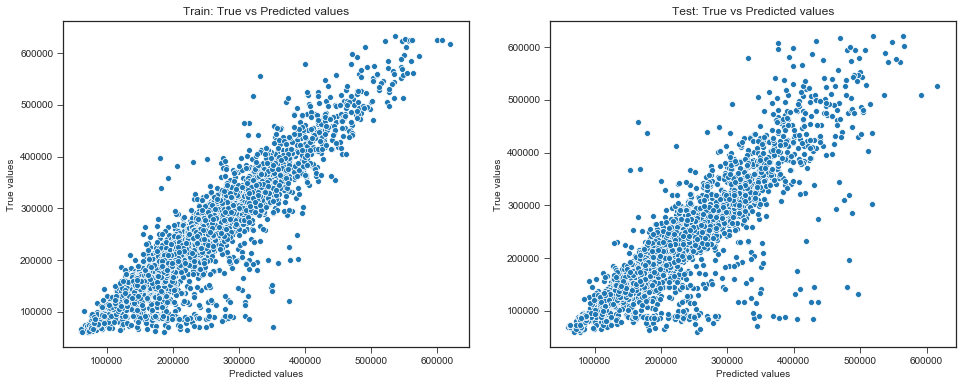

In [18]:
y_train_preds = ctb.predict(X_train)
y_valid_preds = ctb.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

In [19]:
y_model1 = y_valid_preds

y_model1.shape

(3973,)

In [20]:
y_test_model1 = ctb.predict(df_test2_copy)

In [21]:
y_test_model1.shape

(5000,)

#### Random forest

In [22]:
from sklearn.ensemble import RandomForestRegressor

In [23]:
X_train = df_train1.drop('Price', axis=1)
y_train = df_train1['Price']

X_valid = df_train2.drop('Price', axis=1)
y_valid = df_train2['Price']

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((5959, 40), (5959,), (3973, 40), (3973,))

In [24]:
forest = RandomForestRegressor(max_depth=19, 
                               max_features=5, 
                               n_estimators=400,
                               random_state=42)

In [25]:
forest.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
y_train_preds = forest.predict(X_train)
y_valid_preds = forest.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

In [170]:
y_model2 = y_valid_preds

y_model2.shape

(3976,)

In [174]:
y_test_model2 = forest.predict(df_test)

In [175]:
y_test_model1.shape

(5000,)

#### GradientBoostingRegressor

In [176]:
from sklearn.ensemble import GradientBoostingRegressor

In [177]:
X_train = df_train1.drop('Price', axis=1)
y_train = df_train1['Price']

X_valid = df_train2.drop('Price', axis=1)
y_valid = df_train2['Price']

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((5964, 36), (5964,), (3976, 36), (3976,))

In [178]:
gb = GradientBoostingRegressor(max_depth=6, n_estimators=200,
                               random_state=42, learning_rate=0.25)

In [179]:
gb.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.25, loss='ls', max_depth=6,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Train:	R2 = 0.99064	MAE = 6524.42576
Test:	R2 = 0.73789	MAE = 28454.72913


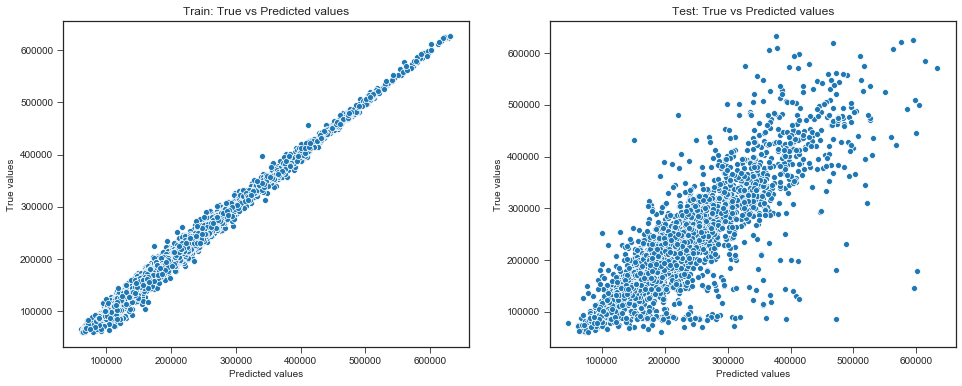

In [180]:
y_train_preds = gb.predict(X_train)
y_valid_preds = gb.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

In [181]:
y_model3 = y_valid_preds

y_model3.shape

(3976,)

In [182]:
y_test_model3 = gb.predict(df_test)

In [183]:
y_test_model3.shape

(5000,)

#### XGBoost

In [184]:
from xgboost import XGBRegressor

In [185]:
X_train = df_train1.drop('Price', axis=1)
y_train = df_train1['Price']

X_valid = df_train2.drop('Price', axis=1)
y_valid = df_train2['Price']

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((5964, 36), (5964,), (3976, 36), (3976,))

In [186]:
xgb = XGBRegressor(max_depth=6, n_estimators=200,
                               random_state=42, learning_rate=0.25)

In [187]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.25, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

Train:	R2 = 0.98781	MAE = 7185.83699
Test:	R2 = 0.74555	MAE = 27844.00991


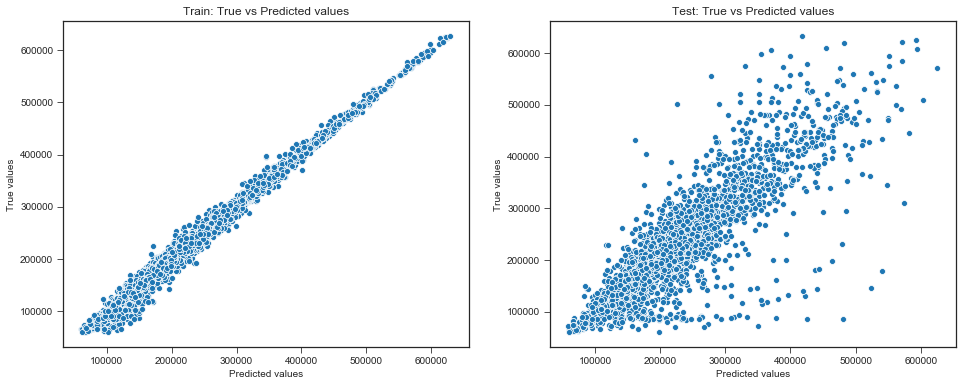

In [188]:
y_train_preds = xgb.predict(X_train)
y_valid_preds = xgb.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

In [189]:
y_model4 = y_valid_preds

y_model4.shape

(3976,)

In [190]:
y_test_model4 = xgb.predict(df_test)

In [192]:
y_test_model4.shape

(5000,)

#### Новая матрица признаков

In [193]:
X_meta = pd.DataFrame()

X_meta['model1'] = y_model1
X_meta['model2'] = y_model2
X_meta['model3'] = y_model3
X_meta['model4'] = y_model4


X_meta.index = df_train2.index


X_meta.shape

(3976, 4)

In [194]:
X_meta.head()

,model1,model2,model3,model4
Id,,,,
10118,183570.152,180169.630,188023.057,197132.016
9098,265890.131,239959.066,289247.795,286934.031
13928,459174.129,405080.883,341337.072,446058.031
6121,220454.716,214172.504,213297.766,209616.344
11167,163379.713,175448.749,171053.035,167583.625


In [195]:
X_meta_test = pd.DataFrame()

X_meta_test['model1'] = y_test_model1
X_meta_test['model2'] = y_test_model2
X_meta_test['model3'] = y_test_model3
X_meta_test['model4'] = y_test_model4


X_meta_test.index = df_test.index


X_meta_test.shape

(5000, 4)

In [196]:
X_meta_test.head()

,model1,model2,model3,model4
Id,,,,
725,164736.103,164595.830,155378.596,155046.016
15856,213912.300,229330.315,216083.283,219845.016
5480,163686.148,252090.310,190853.014,194250.688
15664,329407.980,319894.452,290900.490,286323.531
14275,139398.323,148129.400,149984.680,155109.688


#### Обучаем мета-алгоритм Catboost

In [197]:
from sklearn.model_selection import KFold, cross_val_score

In [198]:
X_meta.shape, y_valid.shape

((3976, 4), (3976,))

In [199]:
forest_meta = RandomForestRegressor(max_depth=4, 
                               max_features=2, 
                               n_estimators=400,
                               random_state=42)

In [200]:
kf = KFold(n_splits=3, random_state=42, shuffle=True)

cv_score = cross_val_score(forest_meta, X_meta, y_valid, scoring='r2', cv=kf)
print('R2: {:.5f}'.format(cv_score.mean()))

R2: 0.77879


In [202]:
forest_meta.fit(X_meta, y_valid)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=4, max_features=2, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=400, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

### Обучаем тестовый датасет

In [203]:
y_pred = forest_meta.predict(X_meta_test)

In [204]:
preds = pd.DataFrame()
preds['Id'] = df_test.index
preds['Price'] = y_pred

In [205]:
preds.to_csv('submission.csv', index=False)